Classification / Round 01
<hr size=1>

Target: Classify Surface Contour and Echotexture in 1964 US Images

Pulled From:
(Hello World in Google Drive)
1. https://colab.research.google.com/drive/1RaZLIPHXcM0z0MRsdtc-njrb48p9zEts?authuser=1#scrollTo=BdMj8z10Z3Ni

Based On:
1. https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python
2. https://github.com/ImagingInformatics/machine-learning/blob/master/SiiM2019/MLcourse_Notebook_1_update.ipynb

Major Modification:

Learning Points:
1. Tends to have best at around 140 epochs, overfitting at about 160
2. Overfitting delayed with higher dropout (0.5, 0.2); but no improvement in accuracy before overfitting
3. Cyclical LR (exp 1e-5 to 5 x 1e-3)will learn. Non cyclical with not learn.

Model Weights: 
1. class_best_model_nb1_v1.h5: 0.68 accuracy on test


In [1]:
import os
import os.path
from os import path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import to_categorical

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
#from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import *

from keras.optimizers import Adam, SGD

from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
# For RTX cards
# https://medium.com/@noel_kennedy/how-to-use-half-precision-float16-when-training-on-rtx-cards-with-tensorflow-keras-d4033d59f9e4

import keras.backend as K
dtype='float16'
K.set_floatx(dtype)
# default is 1e-7 which is too small for float16.  Without adjusting the epsilon, we will get NaN predictions because of divide by zero problems
K.set_epsilon(1e-4) 

In [3]:
# simple confirmation function
def confirm(question):
    reply = str(input(question+' (y/n): ')).lower().strip()
    if reply[0] == 'y':
        return True
    if reply[0] == 'n':
        return False
    else:
        return confirm("Choices are ")

In [4]:
# Cyclical Learning Rate
# https://github.com/bckenstler/CLR/blob/master/clr_callback.py

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=1e-6, max_lr=1e-3, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

clr_triangular = CyclicLR(mode='triangular')
clr_exp = CyclicLR(mode='exp_range')

In [5]:
# Histogram Equalization
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html

import cv2
import numpy as np
from matplotlib import pyplot as plt

def histogram_equalization(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    img2 = cdf[img]
    return img2

"""
img = cv2.imread("output_parenchyma/61604190_parenchyma.png",0)

img2 = histogram_equalization(img)

figure, ax = plt.subplots(1,2, figsize=(6.4,6.4), dpi=100)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(img2, cmap='gray')
"""

'\nimg = cv2.imread("output_parenchyma/61604190_parenchyma.png",0)\n\nimg2 = histogram_equalization(img)\n\nfigure, ax = plt.subplots(1,2, figsize=(6.4,6.4), dpi=100)\nax[0].imshow(img, cmap=\'gray\')\nax[1].imshow(img2, cmap=\'gray\')\n'

In [6]:
IMG_HEIGHT = 64
IMG_WIDTH = 64

<b>Things I Tried In The Next Cell:</b>
1. Histogram Equalization - does not seem to change training behaviour
2. Feeding "images_raw", which is the unsegmented image - no change in training behaviour

In [22]:
import csv

#populate training and testing sets
train_X = []
train_Y_surface = []
train_Y_parenchyma = []
test_X = []
test_Y_surface = []
test_Y_parenchyma = []

with open('csv/US_Report_Master.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0: #ignore header
            #print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            # Load Images
            # Comment out as necessary, to train either surface or parenchyma
            #im = Image.open("images_raw/" + row[0] + ".png", "r")
            #im = Image.open("output_surface/" + row[0] + "_surface.png", "r")
            im = Image.open("output_parenchyma/" + row[0] + "_parenchyma.png", "r")
            
            im = im.resize((IMG_WIDTH,IMG_HEIGHT))
            pixelarray = np.array(list(im.getdata(0)))
            
            # Comment out to apply histogram equalization
            #pixelarray = histogram_equalization(pixelarray)
            
            pixelarray = np.reshape(pixelarray, (IMG_WIDTH,IMG_HEIGHT))
            if row[1] == "TRAIN": # TRAIN images
                train_X.append(pixelarray)
                #load ground truths
                train_Y_surface.append(row[2])
                train_Y_parenchyma.append(row[3])
            else: # TEST images
                test_X.append(pixelarray)
                #load ground truths
                test_Y_surface.append(row[2])
                test_Y_parenchyma.append(row[3])

# Comment out as necessary, to train either surface or parenchyma
train_X = np.array(train_X)
#train_Y = np.array(train_Y_surface)
train_Y = np.array(train_Y_parenchyma)
test_X = np.array(test_X)
#test_Y = np.array(test_Y_surface)
test_Y = np.array(test_Y_parenchyma)

Total number of outputs :  2
Output classes :  ['0' '1']
Original label: 0
After conversion to one-hot: [1. 0.]


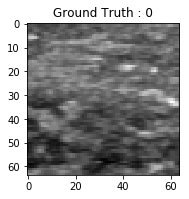

In [8]:
#from https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python

# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[200,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[200]))

# Reshape to IMG_HEIGHT x IMG_WIDTH x 1
train_X = train_X.reshape(-1, IMG_WIDTH,IMG_HEIGHT, 1)
test_X = test_X.reshape(-1, IMG_WIDTH,IMG_HEIGHT, 1)

# Normalize 0-255 to 0-1
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

In [9]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(1639, 64, 64, 1)
(1639,)
(325, 64, 64, 1)
(325,)


In [10]:
# Split training data to 85/15
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.15, random_state=13)

print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(1393, 64, 64, 1) (246, 64, 64, 1) (1393, 2) (246, 2)


<b>Things I Tried In The Next Cell:</b>
1. This model from datacamp doesn't seem to work

In [11]:
"""
### NEURAL NET
num_classes = nClasses

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(IMG_HEIGHT,IMG_WIDTH,1),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(lr = 1e-4),metrics=['accuracy'])
"""

"\n### NEURAL NET\nnum_classes = nClasses\n\nmodel = Sequential()\nmodel.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(IMG_HEIGHT,IMG_WIDTH,1),padding='same'))\nmodel.add(LeakyReLU(alpha=0.1))\nmodel.add(MaxPooling2D((2, 2),padding='same'))\nmodel.add(Conv2D(64, (3, 3), activation='linear',padding='same'))\nmodel.add(LeakyReLU(alpha=0.1))\nmodel.add(MaxPooling2D(pool_size=(2, 2),padding='same'))\nmodel.add(Conv2D(128, (3, 3), activation='linear',padding='same'))\nmodel.add(LeakyReLU(alpha=0.1))                  \nmodel.add(MaxPooling2D(pool_size=(2, 2),padding='same'))\nmodel.add(Flatten())\nmodel.add(Dense(128, activation='linear'))\nmodel.add(LeakyReLU(alpha=0.1))                  \nmodel.add(Dense(num_classes, activation='softmax'))\n\nmodel.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(lr = 1e-4),metrics=['accuracy'])\n"

<b>Things I Tried In The Next Cell:</b>
1. Changing number of conv2d layers between 4 to 8; no change
2. Changing number of filters, range from 16-32 until 32-256; no change
3. Changing number of dense layers between 1 to 2; no change
4. Changing number of neurons in dense layer from 20 to 256; no change
5. Changing dropouts from 0.1 to 0.5; no change
6. Using Adam at lr 1e-4 to 1e-6; model doesn't converge
7. Using SGD at lr 1e-4 to 1e-5; model doesn't converge (Model shows training convergence followed by overfitting when I use cyclical learning rate)

In [12]:
### NEURAL NET
num_classes = nClasses

# Create a basic CNN architecture

inputs = Input((IMG_WIDTH, IMG_HEIGHT, 1))

# Block1
conv1 = Conv2D(16, (3,3), activation = 'relu', padding='same', kernel_initializer='lecun_uniform')(inputs)
conv2 = Conv2D(16, (3,3), activation = 'relu', padding='same', kernel_initializer='lecun_uniform')(conv1)
max1 = MaxPooling2D((2,2), strides = (2,2))(conv2)

# Block2
conv3 = Conv2D(32, (3,3), activation = 'relu', padding='same', kernel_initializer='lecun_uniform')(max1)
conv4 = Conv2D(32, (3,3), activation = 'relu', padding='same', kernel_initializer='lecun_uniform')(conv3)
max2 = MaxPooling2D((2,2), strides = (2,2))(conv4)

# Block3
conv5 = Conv2D(64, (3,3), activation = 'relu', padding='same', kernel_initializer='lecun_uniform')(max2)
conv6 = Conv2D(64, (3,3), activation = 'relu', padding='same', kernel_initializer='lecun_uniform')(conv5)
max3 = MaxPooling2D((2,2), strides = (2,2))(conv6)

fcn = Flatten()(max3)
fcn = Dense(128,activation='relu')(fcn)
fcn = Dropout(0.3)(fcn) #0.2
fcn = Dense(64,activation='relu')(fcn)
fcn = Dropout(0.1)(fcn) #0.1
output = Dense(num_classes,activation='softmax')(fcn)

model = Model(inputs,output)

#model.compile(optimizer=Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), 
#              loss='categorical_crossentropy', metrics=['accuracy'])

model.compile(optimizer=SGD(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

#model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
print(model.summary())
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_Y),
                                                 train_Y)

print(class_weights)
#class_weights = [0.5, 10.0]
#print(class_weights)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [14]:
bestmodelh5 = 'class_best_model_nb1_v4.h5'

<b>Things I Tried In The Next Cell:</b>
1. Batch size between 1 to 50
2. Epochs up 600 (for networks that converge slowly / doesn't converge)
3. Augentation with zoom, horizontal flip and vertical flip (not for raw or surface images)
4. Cyclical LR is required

In [21]:
BS = 4
EPOCHS = 200 #20

# construct the training image generator for data augmentation
aug = keras.preprocessing.image.ImageDataGenerator(
#    rotation_range=30,
#    zoom_range=0.2,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.15,
#    vertical_flip=True,
#    horizontal_flip=True,
#    fill_mode="nearest"
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=400, verbose=2),
    ModelCheckpoint(filepath=bestmodelh5, monitor='val_loss', 
                    save_best_only=True, verbose=2),
    clr_exp
]

# check for previously trained weights to avoid accidentaly overwrite
good_to_go = False

if (path.exists(bestmodelh5)) :
    if (confirm('Overwrite previous h5')):
        good_to_go = True
else :
    good_to_go = True
    
if (good_to_go):
    results = model.fit_generator(
                    aug.flow(train_X, train_label, batch_size=BS),
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_X) // BS,
                    callbacks=callbacks,
                    verbose=1,
                    class_weight=class_weights,
                    validation_data=(valid_X, valid_label),
                    use_multiprocessing=False, 
                    workers=1
                    ) 

Overwrite previous h5 (y/n): y
Epoch 1/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6803 - acc: 0.5704 - val_loss: 0.6749 - val_acc: 0.6341

Epoch 00001: val_loss improved from inf to 0.67491, saving model to class_best_model_nb1_v4.h5
Epoch 2/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6802 - acc: 0.5697 - val_loss: 0.6700 - val_acc: 0.6179

Epoch 00002: val_loss improved from 0.67491 to 0.67005, saving model to class_best_model_nb1_v4.h5
Epoch 3/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6782 - acc: 0.5726 - val_loss: 0.6739 - val_acc: 0.6341

Epoch 00003: val_loss did not improve from 0.67005
Epoch 4/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6809 - acc: 0.5632 - val_loss: 0.6694 - val_acc: 0.6179

Epoch 00004: val_loss improved from 0.67005 to 0.66937, saving model to class_best_model_nb1_v4.h5
Epoch 5/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6784 - acc: 

348/348 [==============================] - 2s 6ms/step - loss: 0.6769 - acc: 0.5790 - val_loss: 0.6703 - val_acc: 0.6341

Epoch 00043: val_loss did not improve from 0.66542
Epoch 44/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6772 - acc: 0.5711 - val_loss: 0.6694 - val_acc: 0.6260

Epoch 00044: val_loss did not improve from 0.66542
Epoch 45/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6803 - acc: 0.5611 - val_loss: 0.6690 - val_acc: 0.6220

Epoch 00045: val_loss did not improve from 0.66542
Epoch 46/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6798 - acc: 0.5639 - val_loss: 0.6743 - val_acc: 0.6301

Epoch 00046: val_loss did not improve from 0.66542
Epoch 47/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6796 - acc: 0.5575 - val_loss: 0.6689 - val_acc: 0.6220

Epoch 00047: val_loss did not improve from 0.66542
Epoch 48/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6794 

348/348 [==============================] - 2s 6ms/step - loss: 0.6707 - acc: 0.5840 - val_loss: 0.6681 - val_acc: 0.6301

Epoch 00087: val_loss did not improve from 0.66502
Epoch 88/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6757 - acc: 0.5639 - val_loss: 0.6688 - val_acc: 0.6260

Epoch 00088: val_loss did not improve from 0.66502
Epoch 89/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6765 - acc: 0.5682 - val_loss: 0.6698 - val_acc: 0.6301

Epoch 00089: val_loss did not improve from 0.66502
Epoch 90/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6740 - acc: 0.5704 - val_loss: 0.6706 - val_acc: 0.6301

Epoch 00090: val_loss did not improve from 0.66502
Epoch 91/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6773 - acc: 0.5618 - val_loss: 0.6711 - val_acc: 0.6341

Epoch 00091: val_loss did not improve from 0.66502
Epoch 92/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6738 


Epoch 00130: val_loss did not improve from 0.66315
Epoch 131/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6749 - acc: 0.5740 - val_loss: 0.6638 - val_acc: 0.6260

Epoch 00131: val_loss did not improve from 0.66315
Epoch 132/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6684 - acc: 0.5812 - val_loss: 0.6665 - val_acc: 0.6138

Epoch 00132: val_loss did not improve from 0.66315
Epoch 133/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6720 - acc: 0.5747 - val_loss: 0.6659 - val_acc: 0.6260

Epoch 00133: val_loss did not improve from 0.66315
Epoch 134/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6776 - acc: 0.5683 - val_loss: 0.6660 - val_acc: 0.6260

Epoch 00134: val_loss did not improve from 0.66315
Epoch 135/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6669 - acc: 0.5884 - val_loss: 0.6646 - val_acc: 0.6260

Epoch 00135: val_loss did not improve from 0.66315
Epoch 136/200

348/348 [==============================] - 2s 6ms/step - loss: 0.6731 - acc: 0.5754 - val_loss: 0.6613 - val_acc: 0.6138

Epoch 00174: val_loss did not improve from 0.66070
Epoch 175/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6742 - acc: 0.5754 - val_loss: 0.6665 - val_acc: 0.6260

Epoch 00175: val_loss did not improve from 0.66070
Epoch 176/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6714 - acc: 0.5920 - val_loss: 0.6651 - val_acc: 0.6220

Epoch 00176: val_loss did not improve from 0.66070
Epoch 177/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6737 - acc: 0.5668 - val_loss: 0.6638 - val_acc: 0.6138

Epoch 00177: val_loss did not improve from 0.66070
Epoch 178/200
348/348 [==============================] - 2s 6ms/step - loss: 0.6703 - acc: 0.5654 - val_loss: 0.6663 - val_acc: 0.6260

Epoch 00178: val_loss did not improve from 0.66070
Epoch 179/200
348/348 [==============================] - ETA: 0s - loss: 0.6667

In [16]:
# WAIT! THINK ABOUT THIS!!!

if (confirm("Load previous weights")):
    model.load_weights(bestmodelh5)

Load previous weights (y/n): n


In [17]:
# WAIT! THINK ABOUT THIS!!!

if (confirm("Save current weights")):
    model.save(bestmodelh5)

Save current weights (y/n): n


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


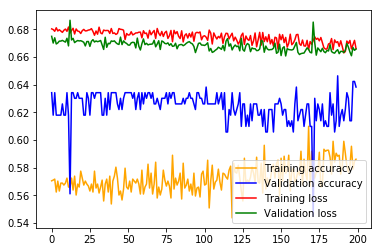

In [24]:
import matplotlib.pyplot as plt

print(results.history.keys())

plt.figure()
plt.plot(results.history['acc'], 'orange', label='Training accuracy')
plt.plot(results.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(results.history['loss'], 'red', label='Training loss')
plt.plot(results.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

<b>Not good practice to use TEST set now, but I plan to redo the random reclassification of data before final (Still awaiting final reader)</b>

In [19]:
# Evaluate Test set
test_eval = model.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.6741120793269231
Test accuracy: 0.5907662259615385


In [20]:
pred_Y = model.predict(test_X)
print(pred_Y)

#for i in test_X[:1]:
#    print(i)

[[0.5317 0.4683]
 [0.5527 0.4475]
 [0.5728 0.4275]
 [0.503  0.497 ]
 [0.587  0.413 ]
 [0.6    0.4   ]
 [0.56   0.4402]
 [0.5674 0.4326]
 [0.5903 0.4097]
 [0.59   0.4102]
 [0.6025 0.3975]
 [0.511  0.4888]
 [0.588  0.4124]
 [0.5454 0.4548]
 [0.5396 0.4604]
 [0.5728 0.4272]
 [0.543  0.457 ]
 [0.558  0.4421]
 [0.545  0.4553]
 [0.5884 0.4116]
 [0.4968 0.5034]
 [0.5366 0.4634]
 [0.592  0.408 ]
 [0.5415 0.4587]
 [0.539  0.461 ]
 [0.5845 0.4158]
 [0.524  0.476 ]
 [0.587  0.4128]
 [0.57   0.4302]
 [0.5796 0.4207]
 [0.54   0.4602]
 [0.556  0.4436]
 [0.5693 0.4307]
 [0.5645 0.4355]
 [0.612  0.3884]
 [0.537  0.463 ]
 [0.524  0.4763]
 [0.5894 0.4104]
 [0.5806 0.4194]
 [0.5713 0.4287]
 [0.607  0.393 ]
 [0.5977 0.4026]
 [0.601  0.399 ]
 [0.583  0.4167]
 [0.602  0.3977]
 [0.5957 0.4043]
 [0.5225 0.4775]
 [0.571  0.4292]
 [0.529  0.4712]
 [0.5894 0.4104]
 [0.556  0.4436]
 [0.594  0.4058]
 [0.5957 0.4045]
 [0.579  0.421 ]
 [0.557  0.443 ]
 [0.551  0.4492]
 [0.5264 0.4739]
 [0.551  0.4495]
 [0.508  0.492